# Data Filter

The Sentinel NDVI time series data have an unexpected amount of outliers that have to be manually removed before being used as input to the models, for this we will perform some experiments on the data. The first part consists of the implementation of the Local Outlier Factor (an unsupervised outlier identifier), while the second part is the implementation of the Savitzky-Golay and Locally Weighted Scatterplot Smoothing polynomial filters.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import utils

from whittaker_smooth import whittaker_smooth

In [2]:
# TODO: Changes these values for parameters on a database.
BASE_DIR = '/home/aargaez/Downloads/Plant-Growth-Cycle-based-on-geospatial-data/DataExtraction/kansas22Data'
bands =  ['B4','B3','B2','B8']

# Dict of the images.
images = utils.load_landsat_image(BASE_DIR, bands)

Opening file /home/aargaez/Downloads/Plant-Growth-Cycle-based-on-geospatial-data/DataExtraction/kansas22Data/S-HARMONIZED_20220402T171849_20220402T172614_T14SPH_02Apr2022_B4.tif
Opening file /home/aargaez/Downloads/Plant-Growth-Cycle-based-on-geospatial-data/DataExtraction/kansas22Data/S-HARMONIZED_20220402T171849_20220402T172614_T14SPH_02Apr2022_B3.tif
Opening file /home/aargaez/Downloads/Plant-Growth-Cycle-based-on-geospatial-data/DataExtraction/kansas22Data/S-HARMONIZED_20220402T171849_20220402T172614_T14SPH_02Apr2022_B2.tif
Opening file /home/aargaez/Downloads/Plant-Growth-Cycle-based-on-geospatial-data/DataExtraction/kansas22Data/S-HARMONIZED_20220402T171849_20220402T172614_T14SPH_02Apr2022_B8.tif
Opening file /home/aargaez/Downloads/Plant-Growth-Cycle-based-on-geospatial-data/DataExtraction/kansas22Data/S-HARMONIZED_20221014T172301_20221014T172302_T14SPH_14Oct2022_B4.tif
Opening file /home/aargaez/Downloads/Plant-Growth-Cycle-based-on-geospatial-data/DataExtraction/kansas22Data/S

In [3]:
# Get the days after plant and the dates.
days, dates = utils.dates_to_day_numbers(images.keys())

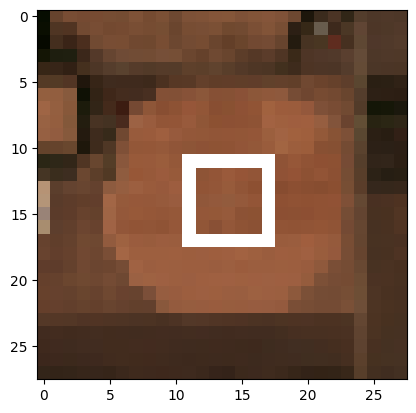

In [4]:
# Calculate the NDVI series over the crop.
ndvi_series = utils.generate_ndvi_time_series(images)

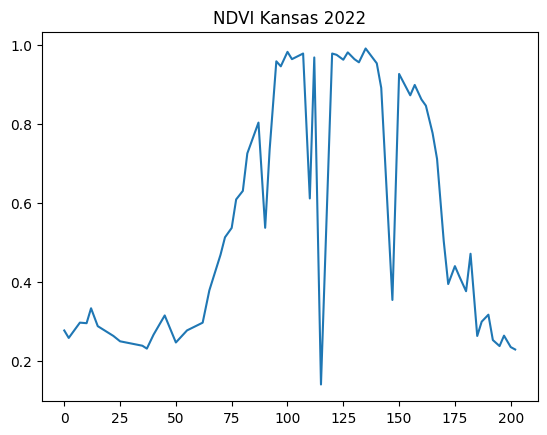

In [5]:
plt.plot(days, ndvi_series)
plt.title('NDVI Kansas 2022')
plt.show()

In [6]:
# Perform a Whittaker Smooth.
y_ = whittaker_smooth(np.array(ndvi_series), lmbd=10)

In [7]:
# Preprocess the data.
x, y = utils.preprocess_data(days, ndvi_series)

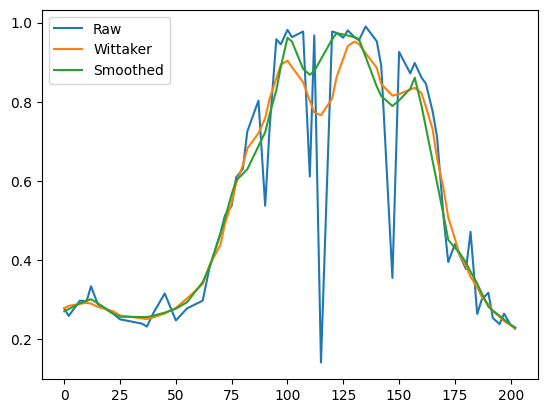

In [8]:
# Plot data.
plt.plot(days, ndvi_series, label='Raw')
plt.plot(days, y_, label='Wittaker')
plt.plot(x, y, label='Smoothed')
plt.legend()
plt.show()